# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo

In [3]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [4]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="SYNTH_dataset",
    description="POLCA-Net on Synthetic Sinudosial and Bent Images",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/SYNTH_dataset


## Generate Synthetic Sinudosial and Bent Images

7.748604e-07 0.9999964
0.0 1.0


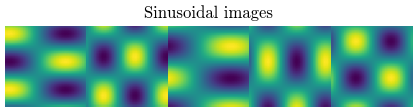

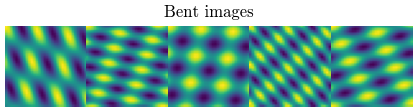

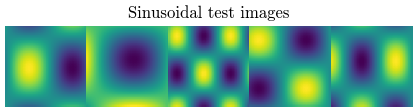

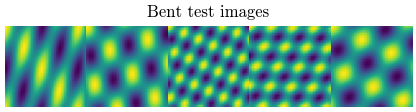

In [5]:
# Parameters
N = 32  # rows
M = 32  # cols
num_samples = 1000

# Generate 2D sinusoidal data
data_sin = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)
data_sin_test = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)

# Generate 2D real bent function images data
data_bent = ut.generate_bent_images(N, M, num_samples=3000)
data_bent_test = ut.generate_bent_images(N, M, num_samples=num_samples)
print(data_sin.min(), data_sin.max())
print(data_bent.min(), data_bent.max())
ut.set_fig_prefix("sin_train")
ut.plot_train_images(data_sin, "Sinusoidal images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_train")
ut.plot_train_images(data_bent, "Bent images", cmap="viridis", n=5)

ut.set_fig_prefix("sin_test")
ut.plot_train_images(data_sin_test, "Sinusoidal test images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_test")
ut.plot_train_images(data_bent_test, "Bent test images", cmap="viridis", n=5)

### Perform PCA on datasets

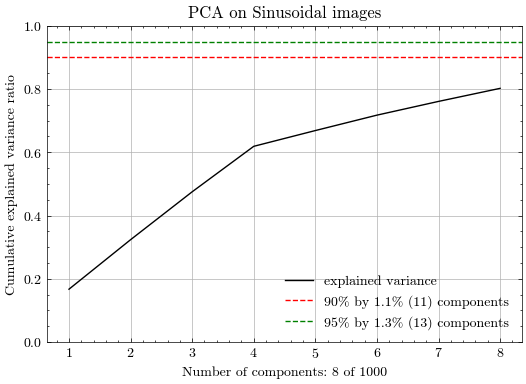

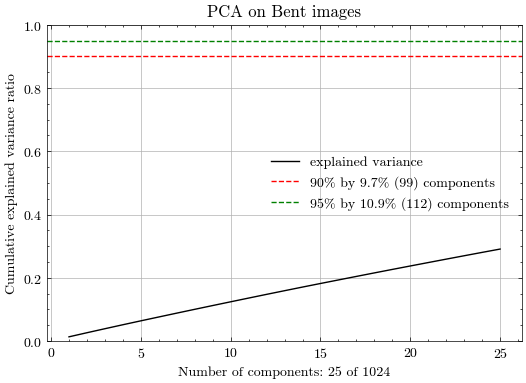

In [6]:
n_components = 8  # int((N*M)//100)
ut.set_fig_prefix("sin")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca_sin = ut.get_pca(data_sin, ax=axs, title="PCA on Sinusoidal images", n_components=n_components)
plt.show()

n_components = 28
ut.set_fig_prefix("bent")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca_bent = ut.get_pca(data_bent, ax=axs, title="PCA on Bent images", n_components=n_components)
plt.show()

## POLCA-Net

### Train on Sinusoidal Images

In [51]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

ae_input = data_sin
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_sin.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_sin = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_sin = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=4,
    act_fn=act_fn,
    bias=False,
    #output_act_fn = torch.nn.Sigmoid,
)

model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    alpha=1e-3,  # ortgogonality loss
    beta=1e-3,  # variance sorting loss
    gamma=1e-4,  # variance reduction loss
)
print(model_sin)
summary = torchinfo.summary(
    model_sin,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_sin), "model_sin.txt")
ut.save_text(str(summary), "model_sin_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=1024, out_features=32, bias=True)
        (12): SiLU()
        (13): Linear(in_features=32, out_features=8, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=False)
      (1): Softsign()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Lin

In [52]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 4.988e-05
Reconstruction Loss: 2.918e-05
Orthogonality Loss: 0.001181
Center of Mass Loss: 0.01663
Variance Reduction Loss: 0.02895


np.float64(4.988407272321638e-05)

In [53]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 1.514e-05
Reconstruction Loss: 6.713e-06
Orthogonality Loss: 0.0009084
Center of Mass Loss: 0.004963
Variance Reduction Loss: 0.0256


np.float64(1.5143980817811098e-05)

In [54]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 1.161e-05
Reconstruction Loss: 4.746e-06
Orthogonality Loss: 0.000498
Center of Mass Loss: 0.003879
Variance Reduction Loss: 0.02484


np.float64(1.1606593943724874e-05)

Loss Interaction Analysis Report:
Total interactions: 9000
Total conflicts: 2275
Overall conflict rate: 0.2528

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,com,var,1500,1215,0.810,-0.210,Strongly Conflicting
1,ort,var,1500,221,0.147,-0.034,Weakly Conflicting
2,rec,com,1500,160,0.107,-0.004,Weakly Conflicting
3,rec,var,1500,105,0.070,0.004,Weakly Cooperative
4,ort,com,1500,164,0.109,0.013,Weakly Cooperative
5,rec,ort,1500,410,0.273,0.076,Weakly Cooperative


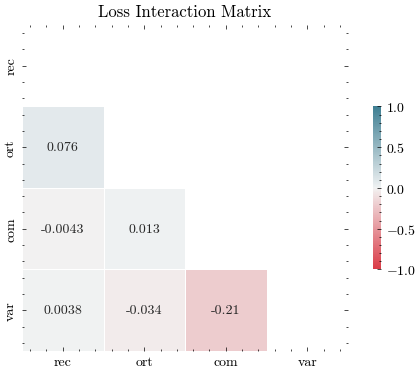

In [55]:
ut.set_fig_prefix("sin_train")
model_sin.loss_analyzer.print_report()
model_sin.loss_analyzer.plot_correlation_matrix(figsize=None)

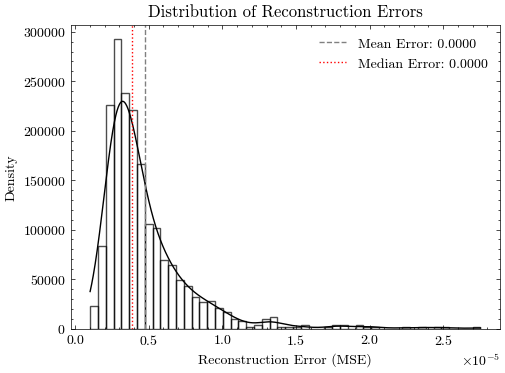

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


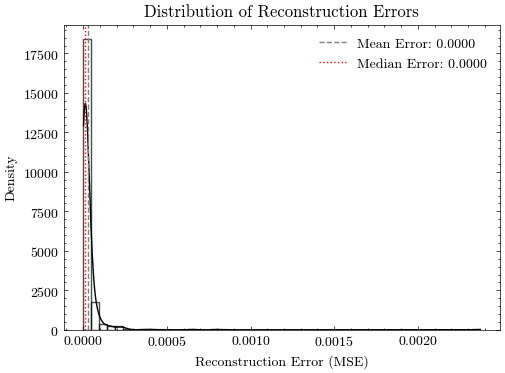

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0024


In [56]:
ut.set_fig_prefix("sin_train")
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=1000)
ut.set_fig_prefix("sin_test")
report.analyze_reconstruction_error(model_sin, data_sin_test, n_samples=1000)

In [13]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 8))

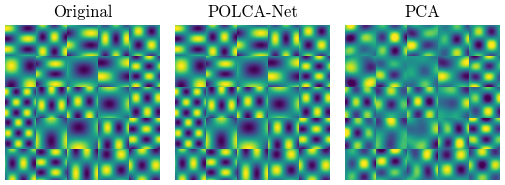

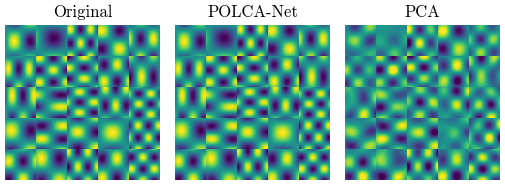

In [57]:
ut.set_fig_prefix("sin_train")
images = data_sin[0:25]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_sin_test[0:25]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0005
    - Max cosine similarity: 0.0054
    - Min cosine similarity: -0.0061
    


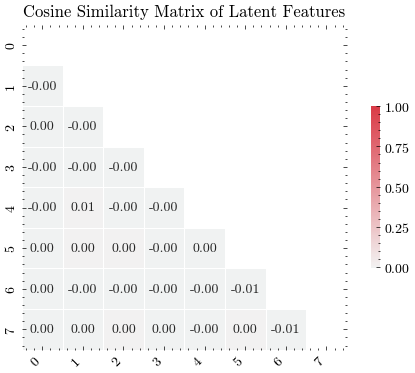

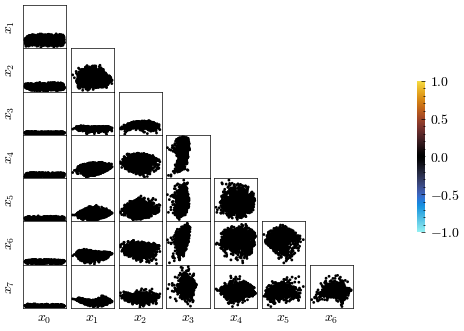

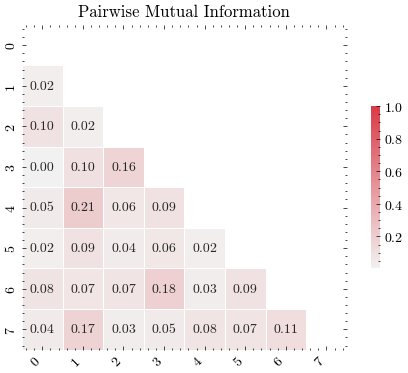


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0097
    - Max cosine similarity: 0.0848
    - Min cosine similarity: -0.1222
    


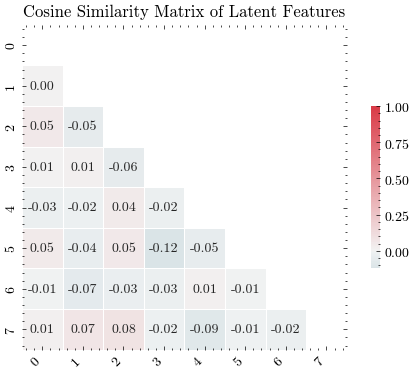

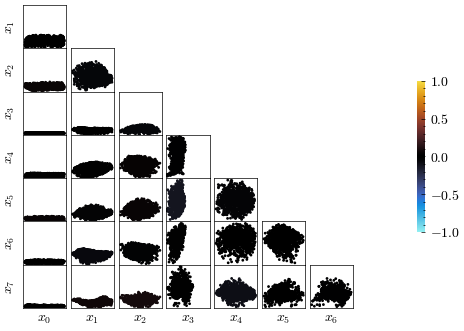

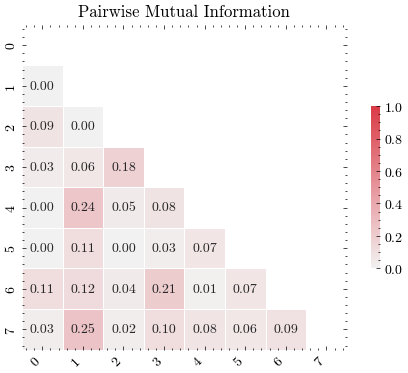

In [58]:
ut.set_fig_prefix("sin_train")
report.orthogonality_test_analysis(model_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.orthogonality_test_analysis(model_sin, data_sin_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.1890
    - Variance fit to exponential distribution (sum of squared differences):
     0.1184
    


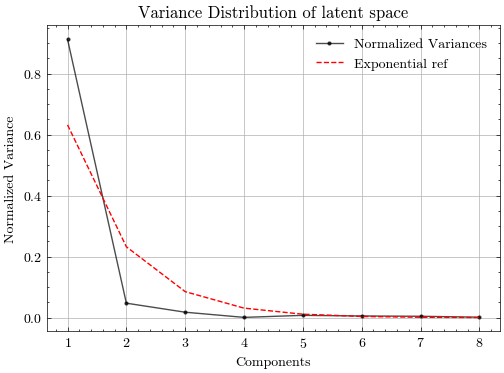

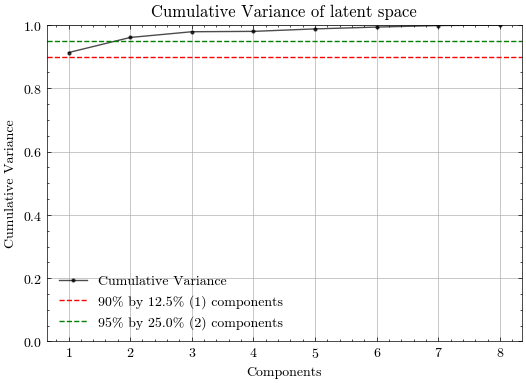

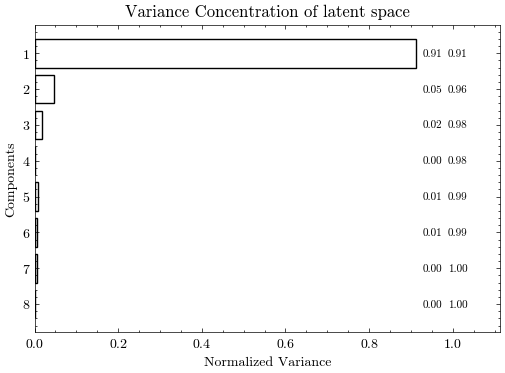


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.1896
    - Variance fit to exponential distribution (sum of squared differences):
     0.1203
    


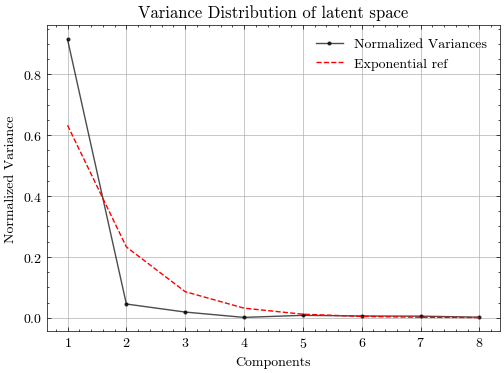

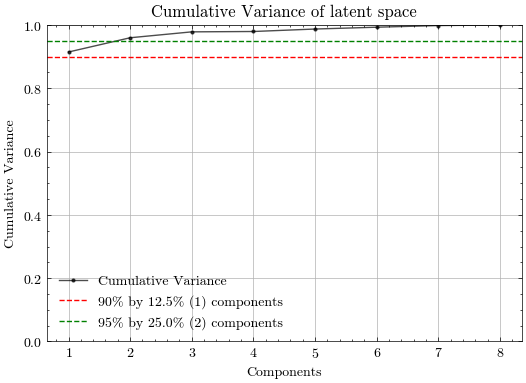

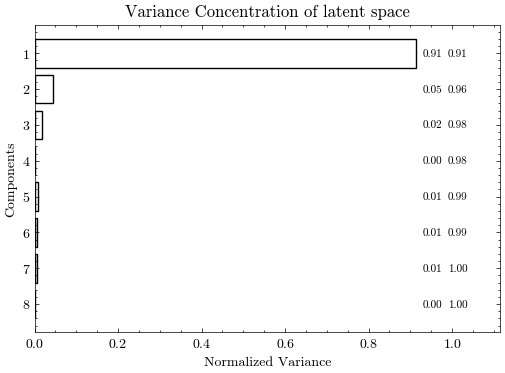

In [59]:
ut.set_fig_prefix("sin_train")
report.variance_test_analysis(model_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.variance_test_analysis(model_sin, data_sin_test)

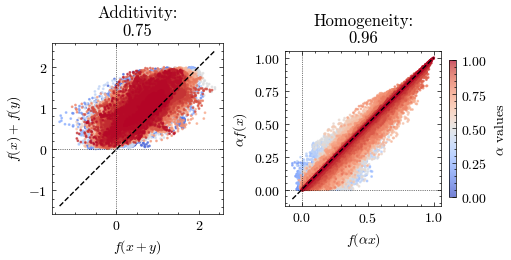

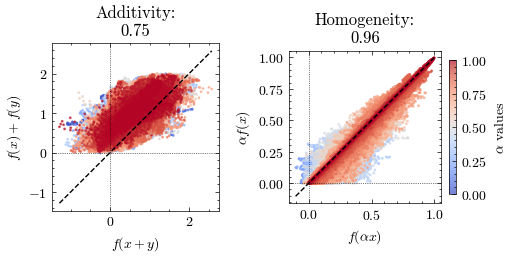

In [60]:
ut.set_fig_prefix("sin_train")
report.linearity_tests_analysis(model_sin, data_sin, alpha_min=0, num_samples=200)
ut.set_fig_prefix("sin_test")
report.linearity_tests_analysis(model_sin, data_sin_test, alpha_min=0, num_samples=200)

### Train on Bent Images

In [61]:
from polcanet.aencoders import ConvEncoder, LinearDecoder
ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_bent.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_bent = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_bent = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=4,
    act_fn=act_fn,
    bias=False,
)

model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    alpha=1e-3,  # ortgogonality loss
    beta=1e-3,  # variance sorting loss
    gamma=1e-4,  # variance reduction loss
)
print(model_bent)
summary = torchinfo.summary(
    model_bent,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_bent), "model_bent.txt")
ut.save_text(str(summary), "model_bent_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=1024, out_features=100, bias=True)
        (12): SiLU()
        (13): Linear(in_features=100, out_features=25, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=25, out_features=25, bias=False)
      (1): Softsign()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0)

In [62]:
model_bent.to("cuda")
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 7.154e-05
Reconstruction Loss: 5.428e-05
Orthogonality Loss: 0.003031
Center of Mass Loss: 0.01133
Variance Reduction Loss: 0.02907


np.float64(7.154035605102156e-05)

In [63]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 1.088e-05
Reconstruction Loss: 3.106e-06
Orthogonality Loss: 0.001709
Center of Mass Loss: 0.003785
Variance Reduction Loss: 0.02278


np.float64(1.0878292869165307e-05)

In [64]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 8.436e-06
Reconstruction Loss: 1.51e-06
Orthogonality Loss: 0.001772
Center of Mass Loss: 0.003019
Variance Reduction Loss: 0.02136


np.float64(8.436220923613291e-06)

Loss Interaction Analysis Report:
Total interactions: 27000
Total conflicts: 2982
Overall conflict rate: 0.1104

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,rec,com,4500,967,0.215,-0.020,Weakly Conflicting
1,rec,var,4500,1098,0.244,-0.019,Weakly Conflicting
2,rec,ort,4500,628,0.140,0.028,Weakly Cooperative
3,ort,var,4500,158,0.035,0.043,Weakly Cooperative
4,ort,com,4500,14,0.003,0.117,Strongly Cooperative
5,com,var,4500,117,0.026,0.522,Strongly Cooperative


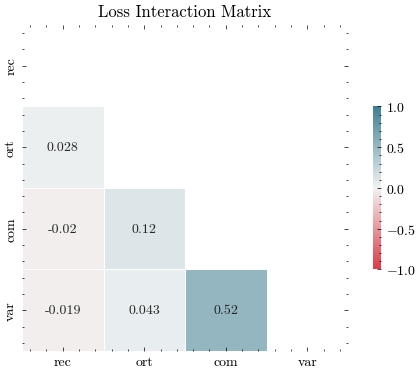

In [65]:
ut.set_fig_prefix("bent_train")
model_bent.loss_analyzer.print_report()
model_bent.loss_analyzer.plot_correlation_matrix(figsize=None)

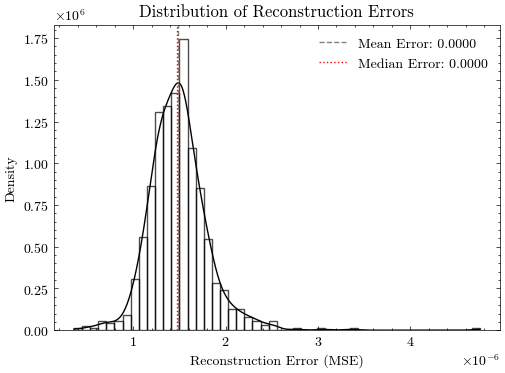

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


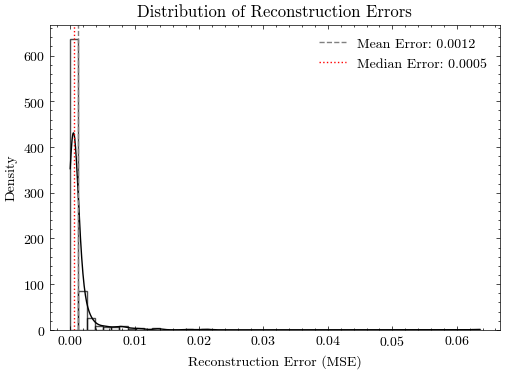

Mean Reconstruction Error: 0.0012
Median Reconstruction Error: 0.0005
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0635


In [66]:
ut.set_fig_prefix("bent_train")
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=1000)
ut.set_fig_prefix("bent_test")
report.analyze_reconstruction_error(model_bent, data_bent_test, n_samples=1000)

In [67]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

((3000, 32, 32), (3000, 32, 32), (3000, 25))

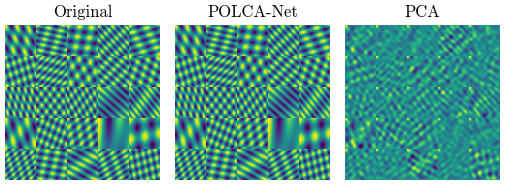

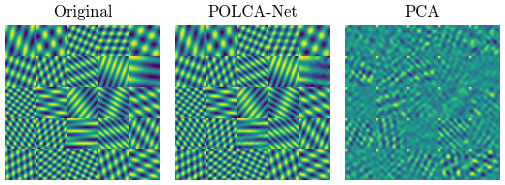

In [68]:
ut.set_fig_prefix("sin_train")
images = data_bent[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_bent_test[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0027
    - Max cosine similarity: 0.0716
    - Min cosine similarity: -0.0776
    


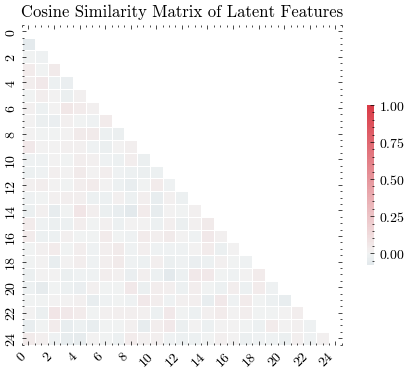

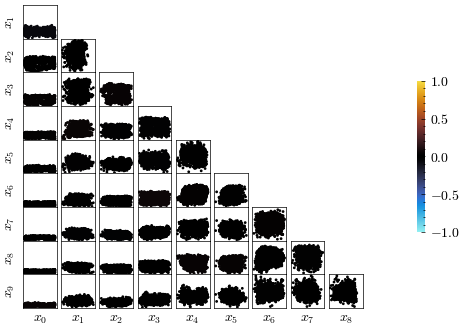

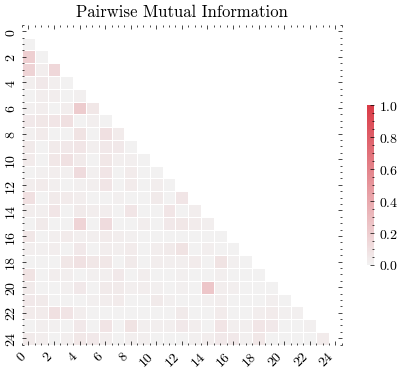


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0022
    - Max cosine similarity: 0.1278
    - Min cosine similarity: -0.1391
    


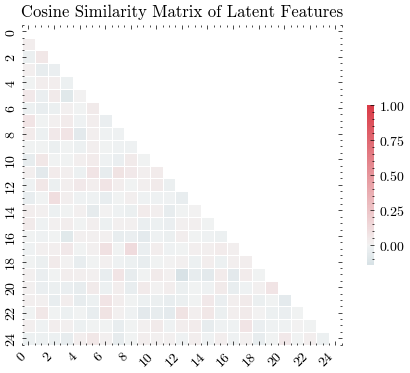

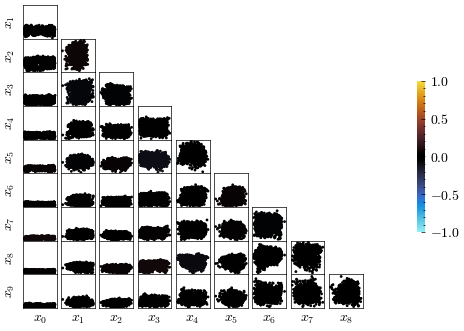

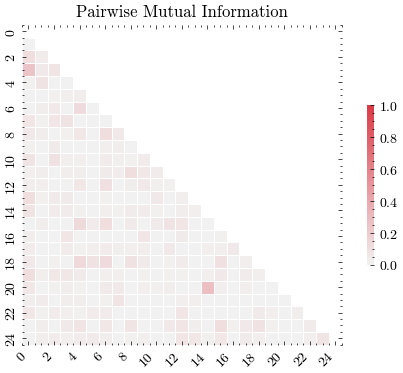

In [69]:
ut.set_fig_prefix("bent_train")
report.orthogonality_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.orthogonality_test_analysis(model_bent, data_bent_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.1628
    - Variance fit to exponential distribution (sum of squared differences):
     0.0552
    


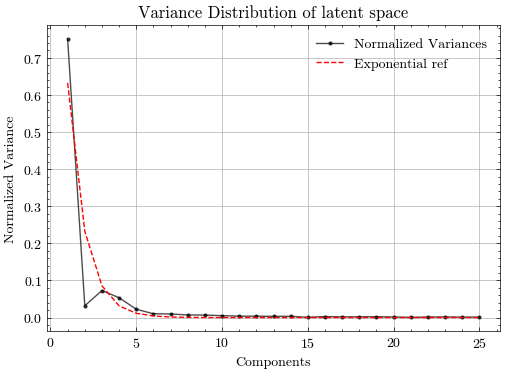

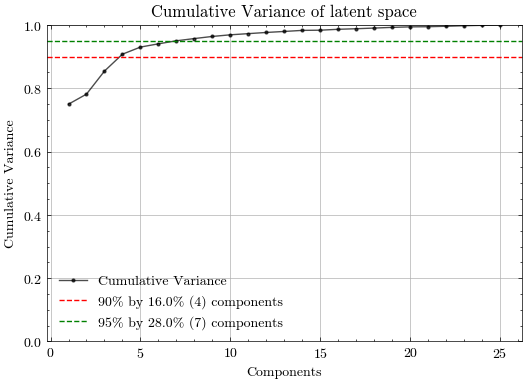

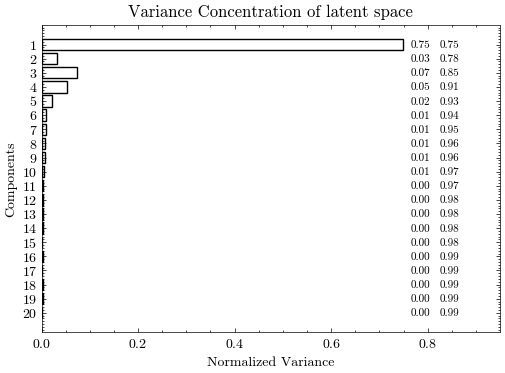


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.1673
    - Variance fit to exponential distribution (sum of squared differences):
     0.0548
    


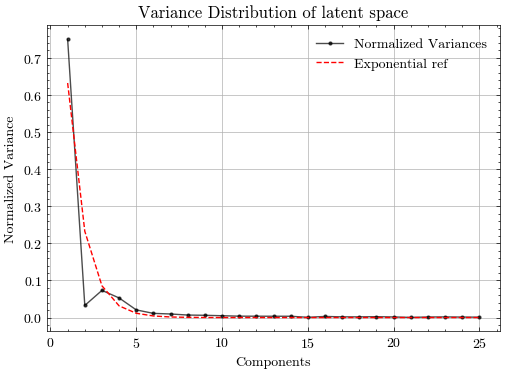

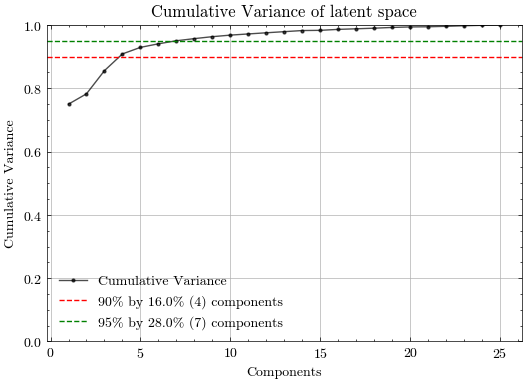

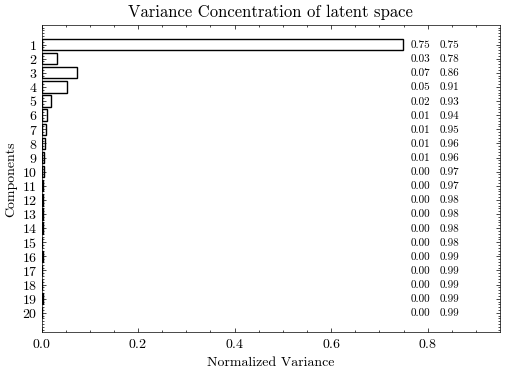

In [70]:
ut.set_fig_prefix("bent_train")
report.variance_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.variance_test_analysis(model_bent, data_bent_test)

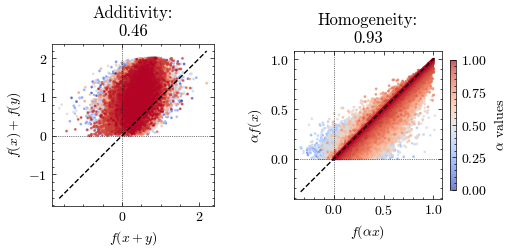

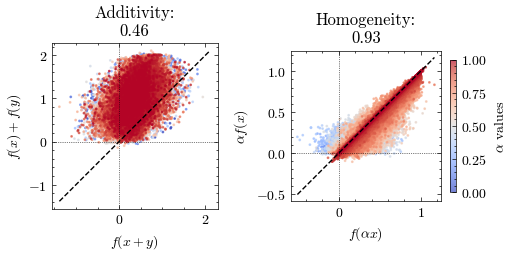

In [71]:
ut.set_fig_prefix("bent_train")
report.linearity_tests_analysis(model_bent, data_bent, alpha_min=0, num_samples=200)
ut.set_fig_prefix("bent_test")
report.linearity_tests_analysis(model_bent, data_bent_test, alpha_min=0, num_samples=200)

## Test Overall

In [72]:
experiment_data = {
    "Sinudoidal": (
        data_sin,
        model_sin,
        pca_sin,
    ),
    "Bent": (
        data_bent,
        model_bent,
        pca_bent,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA Sinudoidal,0.0038,53.8659,0.9999
PCA Sinudoidal,0.1820,20.8163,0.8427
POLCA Bent,0.0022,58.3577,1.0000
PCA Bent,0.3742,13.6371,0.4569


In [5]:
def calculate_compressed_size(initial_size: int, compression_rate: float) -> int:
    """
    Calculate the final size after compression.

    Parameters:
    initial_size (int): The original size before compression.
    compression_rate (float): The desired compression rate (as a decimal).
                              For example, 0.5 for 50% compression.

    Returns:
    int: The final size after compression.
    """
    if compression_rate < 0 or compression_rate > 1:
        raise ValueError("Compression rate must be between 0 and 1.")
    
    final_size = initial_size * compression_rate
    return int(final_size)

In [14]:
# Example usage:
initial_size = 28*28  # Initial size in units (e.g., bytes)
compression_rate = 0.01  # 30% compression rate
compressed_size = max(8,calculate_compressed_size(initial_size, compression_rate))

print(f"The compressed size is {compressed_size} units, from {initial_size} for compression rate {compression_rate}")

The compressed size is 8 units, from 784 for compression rate 0.01


In [19]:
def calculate_compressed_size_and_ratio(initial_size: int, compression_rate: float) -> (int, str):
    """
    Calculate the final size after compression and report the compression ratio.

    Parameters:
    initial_size (int): The original size before compression.
    compression_rate (float): The desired final compression rate (as a decimal).
                              For example, 0.5 means the data is compressed to 50% of the original size.

    Returns:
    tuple: A tuple containing the final size after compression (int) and
           the compression ratio as a string in the format "X:1".
    """
    if compression_rate <= 0 or compression_rate > 1:
        raise ValueError("Compression rate must be between 0 (exclusive) and 1 (inclusive).")
    
    # Calculate the final size after compression
    final_size = initial_size * compression_rate
    compressed_size = int(final_size)
    
    # Calculate the compression ratio
    compression_ratio = initial_size / compressed_size
    compression_ratio_str = f"{compression_ratio:.1f}:1"
    
    return compressed_size, compression_ratio_str

In [23]:
# Example usage:
initial_size = 32*32  # Initial size in units (e.g., bytes)
compression_rate = 0.01  # The final size will be 70% of the original size
compressed_size, compression_ratio = calculate_compressed_size_and_ratio(initial_size, compression_rate)

print(f"The compressed size is {compressed_size} units.")
print(f"The compression ratio is {compression_ratio}")

The compressed size is 10 units.
The compression ratio is 102.4:1
